In [342]:
import os
import numpy as np
import torch
from torch.fft import fft as fft
import torchaudio
from typing import List
import librosa 
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import scipy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

In [59]:
train_data_path_human = '/Users/diat.lov/Downloads/human_spoof_data/Training_Data/human'
train_data_path_spoof = '/Users/diat.lov/Downloads/human_spoof_data/Training_Data/spoof'

In [60]:
human_audio_paths = os.listdir(train_data_path_human)
spoof_audio_paths = os.listdir(train_data_path_spoof)

Observe human and spoof data

In [186]:
human_sample_path = f'{train_data_path_human}/{human_audio_paths[0]}'
spoof_sample_path = f'{train_data_path_spoof}/{spoof_audio_paths[0]}'

In [187]:
ipd.Audio(human_sample_path)

Text(0.5, 1.0, 'Waveform: human voice')

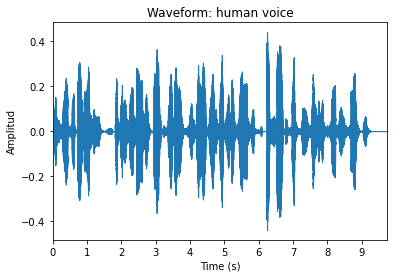

In [195]:
plt.figure()
librosa.display.waveplot(np.array(torchaudio.load(human_sample_path)[0][0]), 16_000)
plt.xlabel('Time (s)')
plt.ylabel('Amplitud')
plt.title('Waveform: human voice')

In [188]:
ipd.Audio(spoof_sample_path)

Text(0.5, 1.0, 'Waveform: spoof voice')

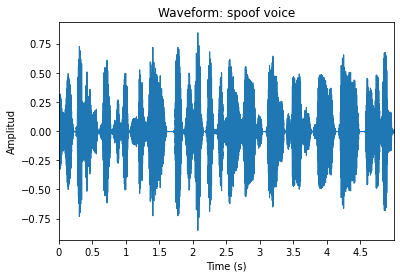

In [196]:
plt.figure()
librosa.display.waveplot(np.array(torchaudio.load(spoof_sample_path)[0][0]), 16_000)
plt.xlabel('Time (s)')
plt.ylabel('Amplitud')
plt.title('Waveform: spoof voice')

Classes are unbalanced: 10322 human voices in train dataset and 39678 spoof. Will take random choice to make audio clips of equal rates for both classes.

In [61]:
spoof_audio_paths = np.random.choice(spoof_audio_paths, len(human_audio_paths))

In [62]:
assert len(human_audio_paths) == len(spoof_audio_paths)

In [63]:
human_audio = [torchaudio.load(f'{train_data_path_human}/{audio}')[0][0] for audio in human_audio_paths]
spoof_audio = [torchaudio.load(f'{train_data_path_spoof}/{audio}')[0][0] for audio in spoof_audio_paths]

In [64]:
human_audio_len = [len(audio) for audio in human_audio]
spoof_audio_len = [len(audio) for audio in spoof_audio]

In [65]:
print(f'human speech, mean, std: {np.mean(human_audio_len)}, {np.std(human_audio_len)}, {np.max(human_audio_len)}')
print(f'spoof speech mean, std: {np.mean(spoof_audio_len)}, {np.std(spoof_audio_len)}, {np.max(spoof_audio_len)}')

human speech, mean, std: 69575.95814764581, 34856.070531183264, 162240
spoof speech mean, std: 71284.27824065104, 32598.5620958086, 162240


In [212]:
human_magnitude = np.abs(human_sample_fft[:np.floor(human_sample_fft.shape[0] / 2).astype(int)])
spoof_magnitude = np.abs(spoof_sample_fft[:np.floor(spoof_sample_fft.shape[0] / 2).astype(int)])

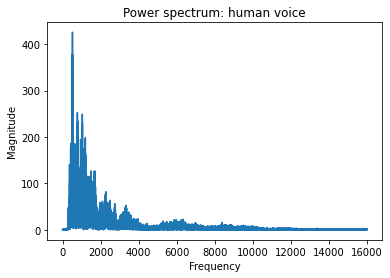

In [213]:
plt.figure()
plt.plot(np.linspace(0, 16_000, human_magnitude.shape[0]), human_magnitude)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('Power spectrum: human voice')
plt.show()

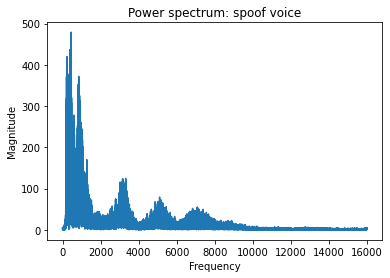

In [214]:
plt.figure()
plt.plot(np.linspace(0, 16_000, spoof_magnitude.shape[0]), spoof_magnitude)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('Power spectrum: spoof voice')
plt.show()

Throw audiofiles shorter than 70_000:

In [273]:
short_human_idx = np.where(np.array(human_audio_len) >= 70_000)[0]
short_spoof_idx = np.where(np.array(spoof_audio_len) >= 70_000)[0]

# balance classes
short_spoof_idx = np.random.choice(short_spoof_idx, len(short_human_idx))

Make all data of the same lenght:

In [279]:
def clip_audio(wav_list: List[List[float]], true_labels_list: np.ndarray, clip_size: int = 70_000) -> torch.tensor:
    data = torch.zeros((len(true_labels_list), clip_size), dtype=torch.double)
    n = 0
    for i, wav in enumerate(wav_list):
        if i in true_labels_list:
            data[n] = wav[:clip_size]
            n += 1
    return data

In [280]:
train_human_tensor = clip_audio(human_audio, short_human_idx)
train_spoof_tensor = clip_audio(spoof_audio, short_spoof_idx)

In [315]:
human_sfft = torch.stft(train_human_tensor[0], n_fft=2048, hop_length=512, onesided=True, center=False, return_complex=True)
spoof_sfft = torch.stft(train_spoof_tensor[0], n_fft=2048, hop_length=512, onesided=True, center=False, return_complex=True)

In [316]:
# almost equal to torch stft, but returns np.array
human_stft_test = scipy.signal.stft(train_human_tensor[:2], nfft=2048, nperseg=1024, noverlap=512, return_onesided=True)[2]

In [317]:
human_stft_magnitude = np.abs(human_sfft)
spoof_stft_magnitude = np.abs(spoof_sfft) 

In [318]:
def plot_histogram(y, hop_length: int = 512, sr: int = 16_000, y_axis='linear'):
    librosa.display.specshow(y, sr=sr, hop_length=hop_length, x_axis='time', y_axis=y_axis)
    plt.colorbar()

Plot spectogram for human and spoof audio

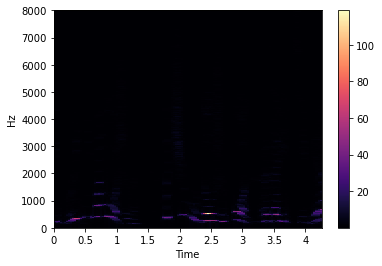

In [319]:
plot_histogram(np.array(human_stft_magnitude))

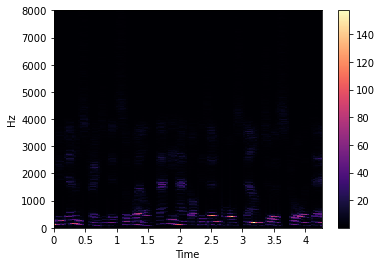

In [320]:
plot_histogram(np.array(spoof_stft_magnitude))

Convert hz to db

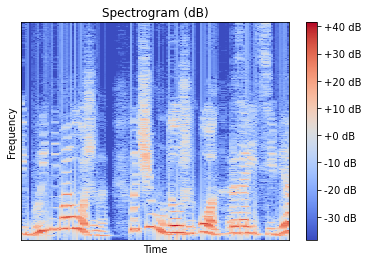

In [321]:
log_human_sample = librosa.amplitude_to_db(np.array(human_stft_magnitude))
plt.figure()
librosa.display.specshow(log_human_sample, sr=16_000, hop_length=512)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(format='%+1.0f dB')
plt.title('Spectrogram (dB)')
plt.show()

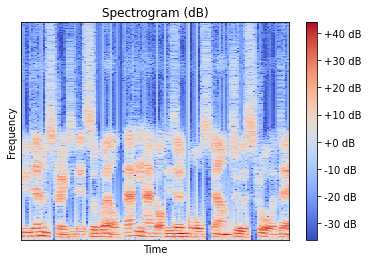

In [287]:
log_spoof_sample = librosa.amplitude_to_db(np.array(spoof_stft_magnitude))
plt.figure()
librosa.display.specshow(log_spoof_sample, sr=16_000, hop_length=512)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(format='%+1.0f dB')
plt.title('Spectrogram (dB)')
plt.show()

Try to build classifier based on db in each frequency averaged by time

In [328]:
def create_db_feature_sample(wav: List[List[float]], n_fft: int = 2048, hop_len: int = 512):
    """
    Function takes a list of wav audiofiles, applises stft, scaled to log and averaged by time frames. 
    :param wav List[List[float]] – n waveforms of audios of 1 class
    :param n_fft: int
    :param hop_len: int
    return: np.array of shape n_fft // 2 + 1
    
    """
    stft = scipy.signal.stft(wav, nfft=n_fft, nperseg=n_fft // 2 + 1, noverlap=hop_len, return_onesided=True)[2]
    log_stft = librosa.amplitude_to_db(np.abs(stft))
    return np.mean(log_stft, axis=1)
    

In [329]:
train_human_data = create_db_feature_sample(train_human_tensor)

In [331]:
train_spoof_data = create_db_feature_sample(train_spoof_tensor)

Build Dataset

In [338]:
X = np.concatenate([train_human_data, train_spoof_data], axis=0)
y = np.concatenate([np.ones(train_human_data.shape[0]), np.zeros(train_spoof_data.shape[0])])

In [341]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42)

Fit Logistic Regression binary classifier

In [352]:
classifier = LogisticRegression(penalty='l2', max_iter=10_000)

In [353]:
classifier.fit(x_train, y_train)

LogisticRegression(max_iter=10000)

In [354]:
classifier.score(x_test, y_test)

0.8411458333333334

Fit K-Means

In [355]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(x_train)

In [356]:
np.sum(kmeans.predict(x_test)==y_test) / y_test.shape[0]

0.384765625